## Import Dependencies

In [40]:
import prettymaps
from PIL import Image
from reportlab.pdfgen import canvas
from reportlab.lib.colors import HexColor
import pandas as pd
import logging

## Filenames and Dimensions

In [41]:
# Dimension of playing card
CARD_WIDTH, CARD_HEIGHT = 822, 1122

# Radius parameter for map generation
MAP_RADIUS = 400

# Set amount of cropping
BORDER_CROP = 210

# Output directory
OUTPUT_DIR = "cards"

# Temporary directory and filenames
MAP_FILE = "tmp/map.png"
CROP_FILE = "tmp/crop.png"

# Assets
LOCATIONS_FILE = "assets/locations.csv"
MASK_FILE = "assets/mask.png"

# Text color & size
PRIMARY_TEXT_COLOR = 0x2F3737
PRIMARY_FONT_TYPE = "Times-Bold"
PRIMARY_TEXT_COLOR = 0x646464
SECONDARY_FONT_TYPE = "Times-Italic"

In [42]:
def get_primary_font_size(text):
    font_sizes = {
        (0, 15): 80,
        (15, 19): 70,
        (19, 25): 60,
        (25, 30): 50,
        (30, 35): 45
    }
    for (start, end), size in font_sizes.items():
        if start <= len(text) < end:
            return size
    return 40

def get_secondary_font_size(text):
    font_sizes = {
        (0, 30): 50,
        (30, 40): 42,
        (40, 45): 35,
    }
    for (start, end), size in font_sizes.items():
        if start <= len(text) < end:
            return size
    return 32

In [43]:
def generate_playing_card(location, title, subtitle):
    """
    Generate a playing card with a map, title, and subtitle.

    Args:
        location (str): Location for the map.
        title (str): Title of the playing card.
        subtitle (str): Subtitle of the playing card.

    Returns:
        None
    """
    
    # Generate map plot
    plot = prettymaps.plot(location, radius=MAP_RADIUS, show=False)

    # Save map plot
    plot.fig.savefig(MAP_FILE, transparent=False, dpi=200)

    # Crop image border
    im = Image.open(MAP_FILE)
    im = im.crop((BORDER_CROP, BORDER_CROP, im.width - BORDER_CROP, im.height - BORDER_CROP))

    # Crop to fit card size
    map_scale = CARD_HEIGHT / im.height
    margin_x = (im.width * map_scale - CARD_WIDTH) / (2 * map_scale)

    im = im.crop((margin_x, 0, im.width - margin_x, im.height))
    im.save(CROP_FILE)

    # Create PDF canvas
    filename = f"{title}-{subtitle}"
    filename = "".join([c for c in filename if c.isalpha() or c.isdigit() or c == ' ']).rstrip()

    # Open canvas image
    c = canvas.Canvas(f"{OUTPUT_DIR}/{filename}.pdf", pagesize=(CARD_WIDTH, CARD_HEIGHT))
    
    # Add map background
    c.drawImage(CROP_FILE, 0, 0, CARD_WIDTH, CARD_HEIGHT)

    # Add overlay
    c.drawImage(MASK_FILE, 0, 0, CARD_WIDTH, CARD_HEIGHT, mask=(0,0,0,0,0,0))

    # Primary text offset
    if subtitle:
        offset = 200
    else:
        offset = 230

    # Add primary text
    c.setFont(PRIMARY_FONT_TYPE, get_primary_font_size(title))
    c.setFillColor(HexColor(PRIMARY_TEXT_COLOR))
    c.drawCentredString(CARD_WIDTH / 2, CARD_HEIGHT - offset, title)

    # Add secondary text
    if subtitle:
        c.setFont(SECONDARY_FONT_TYPE, get_secondary_font_size(subtitle))
        c.setFillColor(HexColor(PRIMARY_TEXT_COLOR))
        c.drawCentredString(CARD_WIDTH / 2, CARD_HEIGHT - 270, subtitle)
    
    # Close canvas image
    c.save()


Generating card for Großer Abenteuerspielplatz ...


KeyboardInterrupt: 

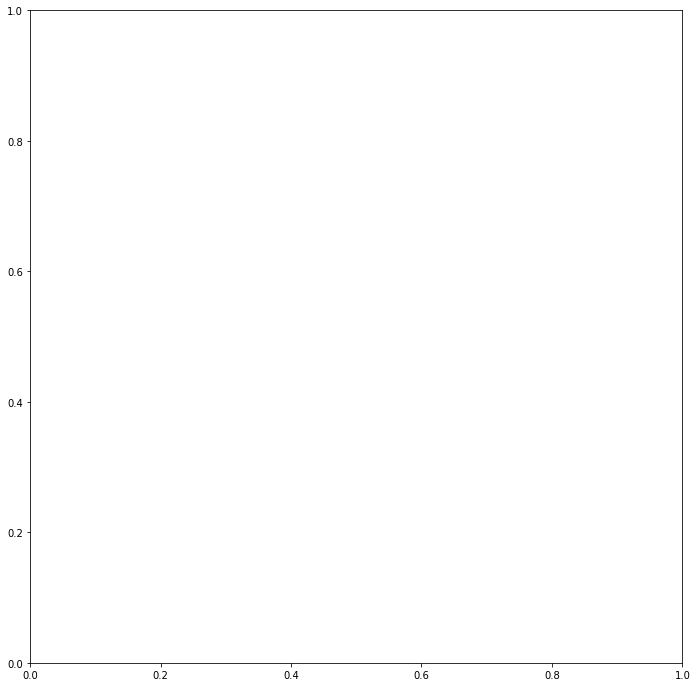

In [44]:
# Suppress warnings from matplotlib
logging.getLogger('matplotlib').setLevel(logging.ERROR)

def isNaN(num):
    return num != num

# Read csv file in form of list of lists
locations = pd.read_csv(LOCATIONS_FILE)

for i, l in locations.iterrows():
    if (isNaN(l['Generated']) or not bool(l['Generated']) or l['Generated'] == "0.0") and not isNaN(l['OSM']):
        print("Generating card for", l['Name'], "...")

        if isNaN(l['Beschreibung']):
            generate_playing_card(l['OSM'], l['Name'], None)
        else:
            generate_playing_card(l['OSM'], l['Name'], l['Beschreibung'])
        
        locations.loc[i, 'Generated'] = True
        locations.to_csv(LOCATIONS_FILE, index=False)

In [ ]:
def reset_generated_locations():

    # Read csv file in form of list of lists
    locations = pd.read_csv(LOCATIONS_FILE)

    for i, l in locations.iterrows():
        if bool(l['Generated']):
            locations.loc[i, 'Generated'] = False
    
    locations.to_csv(LOCATIONS_FILE, index=False)

# reset_generated_locations()